## 1. Prepare the environment

In this section I will import the sample data and play with data shape and types for understanding it

In [1]:
%matplotlib inline
import os
import pandas as pd
import json
import numpy as np
import requests

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
from IPython.core.display import HTML

def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

In [6]:
os.chdir("/Users/ilker/Downloads")

In [7]:
!pwd

/Users/ilker/Downloads


In [8]:
!ls | grep 'sample_data.json'  # this is the file

sample_data.json


In [9]:
!head -20 sample_data.json

## 2. Get the data

In [10]:
with open('sample_data.json') as json_data:
    d = json.load(json_data)
json_data.close()

In [11]:
len(d)  # size of the sample

20000

In [12]:
type(d) # data is stored in a list

list

In [13]:
d[0]  # this is the first dictionary inside the data

{u'Announced At': u'19-09-17 14:04',
 u'Created At': u'19-09-17 14:04',
 u'From Country': u'NL',
 u'Parcel Status Id': 11,
 u'Postal Code': u'3771AB',
 u'Shipped At': u'19-09-17 20:57',
 u'Shipping Method Id': 9,
 u'Updated At': u'20-09-17 12:22'}

In [14]:
df = pd.DataFrame(d)  # convert data to a pandas data frame

In [15]:
df.shape  # there are 8 columns and 20k rows, read is successful

(20000, 8)

In [16]:
df.head()  # let's see some samples

,Announced At,Created At,From Country,Parcel Status Id,Postal Code,Shipped At,Shipping Method Id,Updated At
0,19-09-17 14:04,19-09-17 14:04,NL,11,3771AB,19-09-17 20:57,9,20-09-17 12:22
1,19-09-17 11:45,19-09-17 11:45,NL,11,1601AB,19-09-17 23:11,1,20-09-17 11:28
2,27-09-17 14:31,27-09-17 14:31,NL,11,2951AB,06-10-17 13:32,1,07-10-17 15:45
3,14-09-17 13:38,14-09-17 13:38,NL,11,5627AB,15-09-17 1:33,323,15-09-17 9:49
4,11-09-17 12:57,11-09-17 12:57,NL,11,1705AB,11-09-17 22:59,340,12-09-17 13:22


### 2.1. Get the parcel and shippping methods info

Let's get parcel statuses and shipping methods by using api

In [17]:
response = requests.get(
  'https://panel.sendcloud.sc/api/v2/parcels/statuses', 
    auth=('key', 'secret_key'))

In [18]:
df_parcel = pd.DataFrame(json.loads(response.content))
df_parcel.head()

,id,message
0,1337,Unknown status - check carrier track & trace p...
1,3,En route to sorting center
2,4,Delivery delayed
3,5,Sorted
4,6,Not sorted


In [19]:
params = {'sender_address':'all'}
response = requests.get(
  'https://panel.sendcloud.sc/api/v2/shipping_methods', 
    auth=('key', 'secret_key'),params=params)

In [20]:
df_methods = [({'id':x['id'],'carrier':x['carrier'],'name':x['name']}) for x in json.loads(response.content)['shipping_methods']]
df_methods = pd.DataFrame(df_methods)

In [21]:
df_methods.head()

,carrier,id,name
0,dhl,117,DHLForYou Drop Off
1,dhl,492,DHLForYou Letterbox Drop Off
2,postnl,1,PostNL Netherlands 0-30kg
3,postnl,2,PostNL with signature 0-30kg
4,postnl,3,PostNL abroad


### 2.2. Add parcel status and shipping methods information to data

In [22]:
df = pd.merge(left=df,right=df_parcel,how='left',left_on='Parcel Status Id',right_on='id',validate="many_to_one")
df = pd.merge(left=df,right=df_methods,how='left',left_on='Shipping Method Id',right_on='id',validate="many_to_one")

In [23]:
df.rename(columns={'id_x':'Matching Parcel status',
                   'id_y':'Matching Shipping Method id',
                   'name':'Shipping Method name',
                   'message':'Parcel Status'},
          inplace=True)

In [24]:
df.head()

,Announced At,Created At,From Country,Parcel Status Id,Postal Code,Shipped At,Shipping Method Id,Updated At,Matching Parcel status,Parcel Status,carrier,Matching Shipping Method id,Shipping Method name
0,19-09-17 14:04,19-09-17 14:04,NL,11,3771AB,19-09-17 20:57,9,20-09-17 12:22,11,Delivered,NaN,NaN,NaN
1,19-09-17 11:45,19-09-17 11:45,NL,11,1601AB,19-09-17 23:11,1,20-09-17 11:28,11,Delivered,postnl,1.0,PostNL Netherlands 0-30kg
2,27-09-17 14:31,27-09-17 14:31,NL,11,2951AB,06-10-17 13:32,1,07-10-17 15:45,11,Delivered,postnl,1.0,PostNL Netherlands 0-30kg
3,14-09-17 13:38,14-09-17 13:38,NL,11,5627AB,15-09-17 1:33,323,15-09-17 9:49,11,Delivered,NaN,NaN,NaN
4,11-09-17 12:57,11-09-17 12:57,NL,11,1705AB,11-09-17 22:59,340,12-09-17 13:22,11,Delivered,NaN,NaN,NaN


### 2.4 Transform, remove , filter, add variables

API didn't return all the shipping methods so if there is no shipping method name I will use shipping method id

In [25]:
# fill shipping method names with shipping method ids if there is no shipping method name
df['Shipping Method name'] = df['Shipping Method name'].fillna(df['Shipping Method Id'])

In [26]:
pd.DataFrame(df.groupby(['Parcel Status Id','Parcel Status'])['Announced At'].count())

,,Announced At
Parcel Status Id,Parcel Status,
3,En route to sorting center,101
5,Sorted,5
6,Not sorted,2
7,Being sorted,291
8,Delivery attempt failed,22
11,Delivered,18974
12,Awaiting customer pickup,22
80,Unable to deliver,8
91,Parcel en route,42


In [27]:
# convert the string date fields into a date type so that we can make calculations on it
for column in ['Announced At','Created At','Shipped At','Updated At']: 
    df[column] = pd.to_datetime(df[column])

Time difference is always zero for "Announced at" and "Created At", so for this dataset we can use one of these columns for this analysis. On a bigger scale this data should be investigated, why is "Announced At" exactly same as "Created At". Why do sendcloud stores this data, is this a data error like automatically assigning created time to the announced at time, Let's not loose time and here just drop one of the columns and proceed further.

In [28]:
print max((df['Announced At'] - df['Created At']).astype('timedelta64[h]'))
print min((df['Announced At'] - df['Created At']).astype('timedelta64[h]'))

0.0
0.0


In [29]:
del df['Announced At']  # There is no difference between announced and created at so we can remove one of them

In [30]:
df['From Country'].unique()  # From country is also constant so let's also delete this

array([u'NL'], dtype=object)

In [31]:
del df['From Country']

In [32]:
df.head()

,Created At,Parcel Status Id,Postal Code,Shipped At,Shipping Method Id,Updated At,Matching Parcel status,Parcel Status,carrier,Matching Shipping Method id,Shipping Method name
0,2017-09-19 14:04:00,11,3771AB,2017-09-19 20:57:00,9,2017-09-20 12:22:00,11,Delivered,NaN,NaN,9
1,2017-09-19 11:45:00,11,1601AB,2017-09-19 23:11:00,1,2017-09-20 11:28:00,11,Delivered,postnl,1.0,PostNL Netherlands 0-30kg
2,2017-09-27 14:31:00,11,2951AB,2017-06-10 13:32:00,1,2017-07-10 15:45:00,11,Delivered,postnl,1.0,PostNL Netherlands 0-30kg
3,2017-09-14 13:38:00,11,5627AB,2017-09-15 01:33:00,323,2017-09-15 09:49:00,11,Delivered,NaN,NaN,323
4,2017-11-09 12:57:00,11,1705AB,2017-11-09 22:59:00,340,2017-12-09 13:22:00,11,Delivered,NaN,NaN,340


Transactions should have the following time order in an ideal case, let's investigate data errors and their impact
* Created At < Announced At < Shipped at < Updated At

In [33]:
df['Updated Created diff'] = (df['Updated At'] - df['Created At']).astype('timedelta64[h]')
df['Updated Shipped diff'] = (df['Updated At'] - df['Shipped At']).astype('timedelta64[h]')
df['Shipped Created diff'] = (df['Shipped At'] - df['Created At']).astype('timedelta64[h]')

There are 266 cases where "Created At" is greater than "Shipped At". Let's investigate if it's specific to something like parcel status, postal code or shipping method

In [34]:
df[df['Created At'] > df['Shipped At']].shape

(266, 14)

Below we see two tables segmented by "Created At" and "Shipped At" comparison. It doesn't look that this is spesific to available parse; status, shipping method or postal code. For futher investigation it can be useful to check 3, 7, 8, 11 and 93 parcel status ids with other dimensions to catch the reason of data error.

For simplicity I only show it for Parcel status, you extend the loop and obtain other comparison tables for other dimensions.

In [35]:
# for dimension in ['Parcel Status Id','Shipping Method Id','Postal Code']:
for dimension in ['Parcel Status']:
    multi_table([
    pd.DataFrame(df[df['Created At' ] > df['Shipped At']].groupby(dimension)['Created At'].count()), 
    pd.DataFrame(df[df['Created At'] <= df['Shipped At']].groupby(dimension)['Created At'].count())])

,Created At
Parcel Status,
Being sorted,7
Delivered,248
Delivery attempt failed,2
En route to sorting center,2
Shipment collected by customer,7
,Created At
Parcel Status,
Awaiting customer pickup,22
Being sorted,284


So we investigated and couldn't find a strong pattern for the records where "Created At" > "Shipped At", I will just remove them from the table as below.

In [36]:
df = df[df['Created At'] <= df['Shipped At']]

In [37]:
df.shape 

(19734, 14)

In [38]:
df[df['Updated At'] < df['Shipped At']].shape

(570, 14)

When we segment the data "Shipped At" and "Updated At" orders we obtain the following tables. I think it's better to exlude those records from our analysis.

In [39]:
# for dimension in ['Parcel Status Id','Shipping Method Id','Postal Code']:
for dimension in ['Parcel Status']:
    multi_table([
    pd.DataFrame(df[df['Shipped At' ] > df['Updated At']].groupby(dimension)['Created At'].count()), 
    pd.DataFrame(df[df['Shipped At'] <= df['Updated At']].groupby(dimension)['Created At'].count())])

,Created At
Parcel Status,
Awaiting customer pickup,3
Being sorted,3
Delivered,530
Delivery attempt failed,4
En route to sorting center,1
Parcel en route,3
Shipment collected by customer,26
,Created At
Parcel Status,


In [40]:
df = df[df['Updated At'] >= df['Shipped At']]

In [41]:
df.shape

(19164, 14)

# 3. Defining delivery quality of the shipment

Delivery start time is tracked by "Shipped At" and "Updated At" can be used for the final delivery to the end user, "Updated Shipped diff" shows the hours between these two time stamps, so I will use that variable to calculate the metric. We can also analyse the time passed before carrier scans the label which may show the sellers performance but as I understand we are trying to understand the carriers' delivery performance. So I will skip analysing the performance of the time passed between "Created At" And "Shipped At"

In [42]:
df.sort_values('Shipped Created diff',ascending=False).head()

,Created At,Parcel Status Id,Postal Code,Shipped At,Shipping Method Id,Updated At,Matching Parcel status,Parcel Status,carrier,Matching Shipping Method id,Shipping Method name,Updated Created diff,Updated Shipped diff,Shipped Created diff
17132,2017-01-12 12:05:00,11,1503AB,2017-12-16 17:38:00,1,2017-12-19 11:42:00,11,Delivered,postnl,1.0,PostNL Netherlands 0-30kg,8183.0,66.0,8117.0
17813,2017-01-12 20:58:00,93,6585AB,2017-12-12 15:36:00,7,2017-12-13 20:08:00,93,Shipment collected by customer,postnl,7.0,PostNL service point 0-30kg,8039.0,28.0,8010.0
14429,2017-01-12 09:12:00,11,1321AB,2017-11-12 15:46:00,2,2017-12-12 12:00:00,11,Delivered,postnl,2.0,PostNL with signature 0-30kg,8018.0,716.0,7302.0
6309,2017-01-09 13:12:00,11,5622AB,2017-11-09 09:50:00,16,2017-11-09 09:50:00,11,Delivered,NaN,NaN,16,7292.0,0.0,7292.0
16880,2017-12-20 20:57:00,11,1057AB,2018-10-01 15:58:00,117,2018-10-01 15:58:00,11,Delivered,dhl,117.0,DHLForYou Drop Off,6835.0,0.0,6835.0


In [43]:
for i in ['Shipped Created diff','Updated Shipped diff']:
    print df[df[i]>500].shape

(2461, 14)
(5336, 14)


### 3.1 Checking the distribution of hours for "Updated Shipped diff"

#### 3.1.1 hours greater than 300

(300, 8000)

(0, 500)

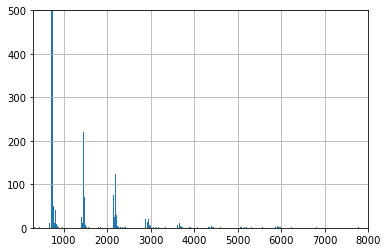

In [44]:
for i in ['Updated Shipped diff']:
    t = df[i].hist(bins=500)
    t.set_xlim((300,8000))
    t.set_ylim((0,500))

#### 3.1.2 hours between 0 and 500

(0, 500)

(0, 2000)

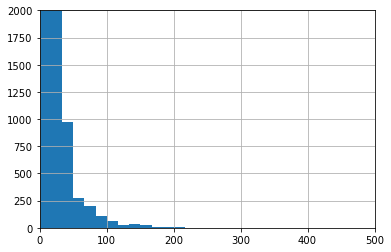

In [45]:
for i in ['Updated Shipped diff']:
    t = df[i].hist(bins=500)
    t.set_xlim((0,500))
    t.set_ylim((0,2000))

In [46]:
df['Updated Shipped diff'].max()

8354.0

### 3.2 Creating intervals for "Updated Shipped diff"

Based on the clusters in the histogram I defined the ranges for the data. I did this because we don't know about the parcel details. Local ranges defined by hours interval can have some logic and finding a metric in its locality will make the thing more comparable or will not inflate standard deviation calculations

In [47]:
df['Updated Shipped ranges'] = pd.cut(df['Updated Shipped diff'],
                                     bins=[0,500,1000,2000,2500,3000,10000],
                                     right=False)

In [48]:
df.groupby('Updated Shipped ranges').aggregate({'Updated Shipped diff':['count','mean','std','min','max']})
df_updated_stats = df.groupby('Updated Shipped ranges').aggregate({'Updated Shipped diff':['mean','std']})

Updated Shipped diff                                    \
                                      count         mean          std     min   
Updated Shipped ranges                                                          
[0, 500)                              13828    22.375036    19.705878     0.0   
[500, 1000)                            4499   727.577239    19.717615   546.0   
[1000, 2000)                            363  1462.903581    49.641522  1021.0   
[2000, 2500)                            303  2186.501650    37.949764  2129.0   
[2500, 3000)                             91  2917.395604    54.472394  2505.0   
[3000, 10000)                            80  4720.237500  1315.422897  3005.0   

                                
                           max  
Updated Shipped ranges          
[0, 500)                 444.0  
[500, 1000)              980.0  
[1000, 2000)            1845.0  
[2000, 2500)            2424.0  
[2500, 3000)            2993.0  
[3000, 10000)           8354.0

### 3.3 Standardize "Updated Shipped diff"

In [50]:
df_t = pd.merge(left=df,right=df_updated_stats,how='left',left_on='Updated Shipped ranges',right_on='Updated Shipped ranges',validate="many_to_one")

In [51]:
def standardize(df, x,m,std):
    df[x+'_normalized'] = (df[x] - df[m]) / df[std]
    return df

In [52]:
df_t = standardize(df_t,x='Updated Shipped diff',m =(u'Updated Shipped diff', u'mean'),std=(u'Updated Shipped diff', u'std'))

In [53]:
df_t.head()

,Created At,Parcel Status Id,Postal Code,Shipped At,Shipping Method Id,Updated At,Matching Parcel status,Parcel Status,carrier,Matching Shipping Method id,Shipping Method name,Updated Created diff,Updated Shipped diff,Shipped Created diff,Updated Shipped ranges,"(Updated Shipped diff, mean)","(Updated Shipped diff, std)",Updated Shipped diff_normalized
0,2017-09-19 14:04:00,11,3771AB,2017-09-19 20:57:00,9,2017-09-20 12:22:00,11,Delivered,NaN,NaN,9,22.0,15.0,6.0,"[0, 500)",22.375036,19.705878,-0.374256
1,2017-09-19 11:45:00,11,1601AB,2017-09-19 23:11:00,1,2017-09-20 11:28:00,11,Delivered,postnl,1.0,PostNL Netherlands 0-30kg,23.0,12.0,11.0,"[0, 500)",22.375036,19.705878,-0.526494
2,2017-09-14 13:38:00,11,5627AB,2017-09-15 01:33:00,323,2017-09-15 09:49:00,11,Delivered,NaN,NaN,323,20.0,8.0,11.0,"[0, 500)",22.375036,19.705878,-0.729480
3,2017-11-09 12:57:00,11,1705AB,2017-11-09 22:59:00,340,2017-12-09 13:22:00,11,Delivered,NaN,NaN,340,720.0,710.0,10.0,"[500, 1000)",727.577239,19.717615,-0.891449
4,2017-08-09 13:51:00,11,1800AB,2017-08-09 23:02:00,16,2017-11-09 10:18:00,11,Delivered,NaN,NaN,16,2204.0,2195.0,9.0,"[2000, 2500)",2186.501650,37.949764,0.223937


In [54]:
df.pivot_table(values='Postal Code', index='Updated Shipped ranges',columns='carrier',aggfunc='count')

carrier,dhl,dpd,postnl
Updated Shipped ranges,,,
"[0, 500)",308,1460,4626
"[500, 1000)",95,617,1917
"[2000, 2500)",10,49,175
"[3000, 10000)",14,38,110
"[2500, 3000)",6,19,30
"[1000, 2000)",4,16,25


In [55]:
df_t.head()

,Created At,Parcel Status Id,Postal Code,Shipped At,Shipping Method Id,Updated At,Matching Parcel status,Parcel Status,carrier,Matching Shipping Method id,Shipping Method name,Updated Created diff,Updated Shipped diff,Shipped Created diff,Updated Shipped ranges,"(Updated Shipped diff, mean)","(Updated Shipped diff, std)",Updated Shipped diff_normalized
0,2017-09-19 14:04:00,11,3771AB,2017-09-19 20:57:00,9,2017-09-20 12:22:00,11,Delivered,NaN,NaN,9,22.0,15.0,6.0,"[0, 500)",22.375036,19.705878,-0.374256
1,2017-09-19 11:45:00,11,1601AB,2017-09-19 23:11:00,1,2017-09-20 11:28:00,11,Delivered,postnl,1.0,PostNL Netherlands 0-30kg,23.0,12.0,11.0,"[0, 500)",22.375036,19.705878,-0.526494
2,2017-09-14 13:38:00,11,5627AB,2017-09-15 01:33:00,323,2017-09-15 09:49:00,11,Delivered,NaN,NaN,323,20.0,8.0,11.0,"[0, 500)",22.375036,19.705878,-0.729480
3,2017-11-09 12:57:00,11,1705AB,2017-11-09 22:59:00,340,2017-12-09 13:22:00,11,Delivered,NaN,NaN,340,720.0,710.0,10.0,"[500, 1000)",727.577239,19.717615,-0.891449
4,2017-08-09 13:51:00,11,1800AB,2017-08-09 23:02:00,16,2017-11-09 10:18:00,11,Delivered,NaN,NaN,16,2204.0,2195.0,9.0,"[2000, 2500)",2186.501650,37.949764,0.223937


### 3.4 Creating the metric

Algorithm for the metric
* For each shipping method and predefined intervals find the average of the "Updated Shipped diff_normalized"
* Multiply each category with it's frequency (this is for weighting)
* Devide the multiplied value by the total number of parcels in that shipping method
* Exclude shipping method if the frequency is less than 30

If the frequency of the shipping methed is less than 30 than it's hard to generalize to say good or bad for the metric, because the sample size is very low. This threshold can be discussed but usually noise can skew data if we don't filter it.

In [56]:
df_t_means = df_t.pivot_table(values='Updated Shipped diff_normalized'
                 ,index='Shipping Method name'
                 ,columns='Updated Shipped ranges'
                 ,aggfunc=['mean']) 

df_t_counts = df_t.pivot_table(values='Updated Shipped diff_normalized'
                 ,index='Shipping Method name'
                 ,columns='Updated Shipped ranges'
                 ,aggfunc=['count'])

In [57]:
df_t_means.columns = df_t_means.columns.levels[1:][0]
df_t_counts.columns = df_t_counts.columns.levels[1:][0]

In [58]:
df_t_counts_sum  = pd.DataFrame(df_t_counts.sum(axis=1))

In [59]:
df_t_weights = df_t_means.multiply(df_t_counts, axis='Shipping Method name')

In [60]:
df_t_metrics = df_t_weights.divide(df_t_counts_sum[0],axis=0)
df_metric = pd.DataFrame(df_t_metrics.sum(axis=1)).sort_values(by=0)
df_metric.rename(columns={0:'metric'},inplace=True)

In [61]:
df_metric = df_metric.join(df_t_counts_sum)
df_metric.rename(columns={0:'count'},inplace=True)

The lower metrics shows a better performance, 

In [62]:
df_metric[df_metric['count']>30]

,metric,count
Shipping Method name,,
271,-0.677945,253.0
326,-0.298421,84.0
323,-0.269130,3128.0
325,-0.205604,74.0
DHLForYou Drop Off,-0.149784,437.0
340,-0.139669,149.0
319,-0.139016,123.0
81,-0.054321,218.0
9,-0.000782,3854.0


Let's take some samples and see if the metric is catching performance. Following 3 charts shows performances of the shipping methods, numbers and charts clearly shows the performance difference between methods.

,Updated Shipped diff
count,253.000000
mean,45.648221
std,226.277885
min,1.000000
25%,5.000000
50%,6.000000
75%,8.000000
max,2215.000000


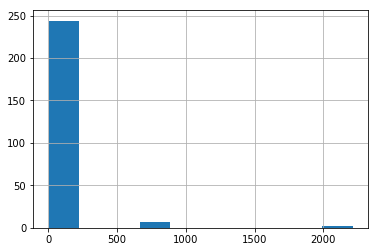

In [63]:
df_t[df_t['Shipping Method name']==271]['Updated Shipped diff'].hist()
pd.DataFrame(df_t[df_t['Shipping Method name']==271]['Updated Shipped diff'].describe())

,Updated Shipped diff
count,437.000000
mean,352.249428
std,689.163686
min,0.000000
25%,16.000000
50%,20.000000
75%,710.000000
max,5968.000000


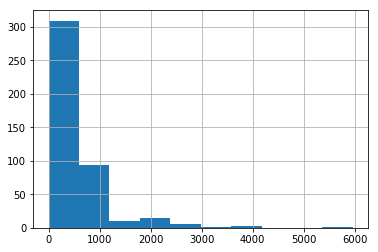

In [64]:
df_t[df_t['Shipping Method name']=='DHLForYou Drop Off']['Updated Shipped diff'].hist()
pd.DataFrame(df_t[df_t['Shipping Method name']=='DHLForYou Drop Off']['Updated Shipped diff'].describe())

,Updated Shipped diff
count,427.000000
mean,361.906323
std,720.908494
min,0.000000
25%,18.500000
50%,24.000000
75%,716.000000
max,7776.000000


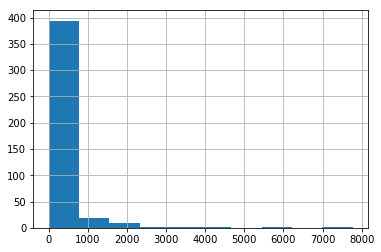

In [65]:
df_t[df_t['Shipping Method name']=='PostNL with signature 0-30kg']['Updated Shipped diff'].hist()
pd.DataFrame(df_t[df_t['Shipping Method name']=='PostNL with signature 0-30kg']['Updated Shipped diff'].describe())

## 4. Getting the best 3 and worst 3 shipping methods

In [66]:
multi_table([df_metric[df_metric['count']>30].head(n=3),df_metric[df_metric['count']>30].tail(n=3)])

,metric,count
Shipping Method name,,
271,-0.677945,253.0
326,-0.298421,84.0
323,-0.269130,3128.0
,metric,count
Shipping Method name,,
PostNL service point 0-30kg,0.459620,174.0
53,0.647650,73.0
DPD Pickup Point,0.842342,98.0


## 5. Adding city information to the data set

In [67]:
df_t.head()

,Created At,Parcel Status Id,Postal Code,Shipped At,Shipping Method Id,Updated At,Matching Parcel status,Parcel Status,carrier,Matching Shipping Method id,Shipping Method name,Updated Created diff,Updated Shipped diff,Shipped Created diff,Updated Shipped ranges,"(Updated Shipped diff, mean)","(Updated Shipped diff, std)",Updated Shipped diff_normalized
0,2017-09-19 14:04:00,11,3771AB,2017-09-19 20:57:00,9,2017-09-20 12:22:00,11,Delivered,NaN,NaN,9,22.0,15.0,6.0,"[0, 500)",22.375036,19.705878,-0.374256
1,2017-09-19 11:45:00,11,1601AB,2017-09-19 23:11:00,1,2017-09-20 11:28:00,11,Delivered,postnl,1.0,PostNL Netherlands 0-30kg,23.0,12.0,11.0,"[0, 500)",22.375036,19.705878,-0.526494
2,2017-09-14 13:38:00,11,5627AB,2017-09-15 01:33:00,323,2017-09-15 09:49:00,11,Delivered,NaN,NaN,323,20.0,8.0,11.0,"[0, 500)",22.375036,19.705878,-0.729480
3,2017-11-09 12:57:00,11,1705AB,2017-11-09 22:59:00,340,2017-12-09 13:22:00,11,Delivered,NaN,NaN,340,720.0,710.0,10.0,"[500, 1000)",727.577239,19.717615,-0.891449
4,2017-08-09 13:51:00,11,1800AB,2017-08-09 23:02:00,16,2017-11-09 10:18:00,11,Delivered,NaN,NaN,16,2204.0,2195.0,9.0,"[2000, 2500)",2186.501650,37.949764,0.223937


In [68]:
# let's remove unused columns
del df_t['Matching Shipping Method id']
del df_t['Matching Parcel status']
del df_t['Updated Created diff']
del df_t['Shipped Created diff']

In [69]:
df_geo = pd.read_csv('https://www.aggdata.com/download_sample.php?file=nl_postal_codes.csv')
df_geo.head()

,Postal Code,Place Name,State,County,Latitude,Longitude
0,9400,Assen,Provincie Drenthe,Gemeente Assen,52.9967,6.5625
1,9401,Assen,Provincie Drenthe,Gemeente Assen,52.9967,6.5625
2,9402,Assen,Provincie Drenthe,Gemeente Assen,52.9967,6.5625
3,9403,Assen,Provincie Drenthe,Gemeente Assen,52.9967,6.5625
4,9404,Assen,Provincie Drenthe,Gemeente Assen,52.9967,6.5625


In [70]:
df_t['Postal Code Int'] = df_t['Postal Code'].apply(lambda x: int(x[:4]))  # get the integer part of the postal code
df_t = pd.merge(left=df_t,right=df_geo,how='left',left_on='Postal Code Int',right_on='Postal Code',validate="many_to_one")

In [71]:
# remove unused columns
del df_t['Postal Code Int']
del df_t['Postal Code_y']

# 6. Finding the best and worst cities

## 6.1 Best cities

In [86]:
df_t_best = df_t[df_t['Shipping Method name'].isin([271,326,323])].groupby(['Place Name','State']).filter(lambda x: len(x) >= 5)

In [87]:
df_t_best_means = df_t_best.pivot_table(values='Updated Shipped diff_normalized'
                 ,index=['Place Name','State','Latitude','Longitude']
                 ,columns='Updated Shipped ranges'
                 ,aggfunc=['mean']) 

df_t_best_counts = df_t_best.pivot_table(values='Updated Shipped diff_normalized'
                 ,index=['Place Name','State','Latitude','Longitude']
                 ,columns='Updated Shipped ranges'
                 ,aggfunc=['count'])

df_t_best_means.head()
df_t_best_counts.head()

mean  \
Updated Shipped ranges                                                                    [0, 500)   
Place Name                                    State                   Latitude Longitude             
's-Hertogenbosch                              Provincie Noord-Brabant 51.6992  5.3042    -0.222017   
't Kabel, Nieuw-Vennep                        Provincie Noord-Holland 52.2400  4.6255    -0.349757   
Aalsmeer                                      Provincie Noord-Holland 52.2592  4.7597    -0.102071   
Almere Buiten                                 Provincie Flevoland     52.3950  5.2764    -0.367006   
Amsterdam Binnenstad en Oostelijk Havengebied Provincie Noord-Holland 52.3666  4.9027    -0.395254   

                                                                                                      \
Updated Shipped ranges                                                                   [500, 1000)   
Place Name                                    State                   Latitude Longitude               
's-Hertogenbosch                              Provincie Noord-Brabant 51.6992  5.3042      -0.642679   
't Kabel, Nieuw-Vennep                        Provincie Noord-Holland 52.2400  4.6255            NaN   
Aalsmeer                                      Provincie Noord-Holland 52.2592  4.7597            NaN   
Almere Buiten                                 Provincie Flevoland     52.3950  5.2764            NaN   
Amsterdam Binnenstad en Oostelijk Havengebied Provincie Noord-Holland 52.3666  4.9027            NaN   

                                                                                                       \
Updated Shipped ranges                                                                   [1000, 2000)   
Place Name                                    State                   Latitude Longitude                
's-Hertogenbosch                              Provincie Noord-Brabant 51.6992  5.3042       -0.130707   
't Kabel, Nieuw-Vennep                        Provincie Noord-Holland 52.2400  4.6255             NaN   
Aalsmeer                                      Provincie Noord-Holland 52.2592  4.7597             NaN   
Almere Buiten                                 Provincie Flevoland     52.3950  5.2764             NaN   
Amsterdam Binnenstad en Oostelijk Havengebied Provincie Noord-Holland 52.3666  4.9027             NaN   

                                                                                                       \
Updated Shipped ranges                                                                   [2000, 2500)   
Place Name                                    State                   Latitude Longitude                
's-Hertogenbosch                              Provincie Noord-Brabant 51.6992  5.3042             NaN   
't Kabel, Nieuw-Vennep                        Provincie Noord-Holland 52.2400  4.6255             NaN   
Aalsmeer                                      Provincie Noord-Holland 52.2592  4.7597             NaN   
Almere Buiten                                 Provincie Flevoland     52.3950  5.2764             NaN   
Amsterdam Binnenstad en Oostelijk Havengebied Provincie Noord-Holland 52.3666  4.9027             NaN   

                                                                                                       \
Updated Shipped ranges                                                                   [2500, 3000)   
Place Name                                    State                   Latitude Longitude                
's-Hertogenbosch                              Provincie Noord-Brabant 51.6992  5.3042             NaN   
't Kabel, Nieuw-Vennep                        Provincie Noord-Holland 52.2400  4.6255             NaN   
Aalsmeer                                      Provincie Noord-Holland 52.2592  4.7597             NaN   
Almere Buiten                                 Provincie Flevoland     52.3950  5.2764             NaN   
Amsterdam Binnenstad en Oos

count  \
Updated Shipped ranges                                                                   [0, 500)   
Place Name                                    State                   Latitude Longitude            
's-Hertogenbosch                              Provincie Noord-Brabant 51.6992  5.3042       105.0   
't Kabel, Nieuw-Vennep                        Provincie Noord-Holland 52.2400  4.6255        29.0   
Aalsmeer                                      Provincie Noord-Holland 52.2592  4.7597        11.0   
Almere Buiten                                 Provincie Flevoland     52.3950  5.2764         7.0   
Amsterdam Binnenstad en Oostelijk Havengebied Provincie Noord-Holland 52.3666  4.9027        29.0   

                                                                                                      \
Updated Shipped ranges                                                                   [500, 1000)   
Place Name                                    State                   Latitude Longitude               
's-Hertogenbosch                              Provincie Noord-Brabant 51.6992  5.3042            1.0   
't Kabel, Nieuw-Vennep                        Provincie Noord-Holland 52.2400  4.6255            NaN   
Aalsmeer                                      Provincie Noord-Holland 52.2592  4.7597            NaN   
Almere Buiten                                 Provincie Flevoland     52.3950  5.2764            NaN   
Amsterdam Binnenstad en Oostelijk Havengebied Provincie Noord-Holland 52.3666  4.9027            NaN   

                                                                                                       \
Updated Shipped ranges                                                                   [1000, 2000)   
Place Name                                    State                   Latitude Longitude                
's-Hertogenbosch                              Provincie Noord-Brabant 51.6992  5.3042             5.0   
't Kabel, Nieuw-Vennep                        Provincie Noord-Holland 52.2400  4.6255             NaN   
Aalsmeer                                      Provincie Noord-Holland 52.2592  4.7597             NaN   
Almere Buiten                                 Provincie Flevoland     52.3950  5.2764             NaN   
Amsterdam Binnenstad en Oostelijk Havengebied Provincie Noord-Holland 52.3666  4.9027             NaN   

                                                                                                       \
Updated Shipped ranges                                                                   [2000, 2500)   
Place Name                                    State                   Latitude Longitude                
's-Hertogenbosch                              Provincie Noord-Brabant 51.6992  5.3042             NaN   
't Kabel, Nieuw-Vennep                        Provincie Noord-Holland 52.2400  4.6255             NaN   
Aalsmeer                                      Provincie Noord-Holland 52.2592  4.7597             NaN   
Almere Buiten                                 Provincie Flevoland     52.3950  5.2764             NaN   
Amsterdam Binnenstad en Oostelijk Havengebied Provincie Noord-Holland 52.3666  4.9027             NaN   

                                                                                                       \
Updated Shipped ranges                                                                   [2500, 3000)   
Place Name                                    State                   Latitude Longitude                
's-Hertogenbosch                              Provincie Noord-Brabant 51.6992  5.3042             NaN   
't Kabel, Nieuw-Vennep                        Provincie Noord-Holland 52.2400  4.6255             NaN   
Aalsmeer                                      Provincie Noord-Holland 52.2592  4.7597             NaN   
Almere Buiten                                 Provincie Flevoland     52.3950  5.2764             NaN   
Amsterdam Binnenstad en Oostelijk

In [88]:
df_t_best_means.columns = df_t_best_means.columns.levels[1:][0]
df_t_best_counts.columns = df_t_best_counts.columns.levels[1:][0]

df_t_best_counts_sum  = pd.DataFrame(df_t_best_counts.sum(axis=1))  # row sum for the deliveries in each range for each place

df_t_best_weights = df_t_best_means.multiply(df_t_best_counts, axis=['Place Name','State','Latitude','Longitude'])

df_t_best_metrics = df_t_best_weights.divide(df_t_best_counts_sum[0],axis=0)
df_best_metric = pd.DataFrame(df_t_best_metrics.sum(axis=1)).sort_values(by=0)
df_best_metric.rename(columns={0:'metric'},inplace=True)

df_best_metric = df_best_metric.join(df_t_best_counts_sum)
df_best_metric.rename(columns={0:'count'},inplace=True)

In [89]:
df_best_metric.head(n=3)

,,,,metric,count
Place Name,State,Latitude,Longitude,,
Leeuwarden,Provincie Friesland,53.2000,5.7833,-0.893252,22.0
Valkenswaard,Provincie Noord-Brabant,51.3508,5.4597,-0.857683,11.0
Rokkeveen-West,Provincie Zuid-Holland,52.0537,4.4924,-0.808418,9.0


In [106]:
df_t_best_means.shape

(62, 6)

## 6.2 Worst cities

In [91]:
df_t_worst = df_t[df_t['Shipping Method name'].isin(['PostNL service point 0-30kg',53,'DPD Pickup Point'])]. \
            groupby(['Place Name','State']).filter(lambda x: len(x) >= 5)

In [92]:
df_t_worst_means = df_t_worst.pivot_table(values='Updated Shipped diff_normalized'
                 ,index=['Place Name','State','Latitude','Longitude']
                 ,columns='Updated Shipped ranges'
                 ,aggfunc=['mean']) 

df_t_worst_counts = df_t_worst.pivot_table(values='Updated Shipped diff_normalized'
                 ,index=['Place Name','State','Latitude','Longitude']
                 ,columns='Updated Shipped ranges'
                 ,aggfunc=['count'])

df_t_worst_means.head()
df_t_worst_counts.head()

mean  \
Updated Shipped ranges                                         [0, 500)   
Place Name         State                   Latitude Longitude             
Alkmaar            Provincie Noord-Holland 52.6317  4.7486          NaN   
Barendrecht        Provincie Zuid-Holland  51.8567  4.5347     0.393359   
Broek in Waterland Provincie Noord-Holland 52.4342  4.9958    -0.384288   
Deventer           Provincie Overijssel    52.2550  6.1639     1.464031   
Diemen             Provincie Noord-Holland 52.3396  4.9626    -0.435004   

                                                                           \
Updated Shipped ranges                                        [500, 1000)   
Place Name         State                   Latitude Longitude               
Alkmaar            Provincie Noord-Holland 52.6317  4.7486      -0.118924   
Barendrecht        Provincie Zuid-Holland  51.8567  4.5347            NaN   
Broek in Waterland Provincie Noord-Holland 52.4342  4.9958            NaN   
Deventer           Provincie Overijssel    52.2550  6.1639      -2.052789   
Diemen             Provincie Noord-Holland 52.3396  4.9626            NaN   

                                                                            \
Updated Shipped ranges                                        [1000, 2000)   
Place Name         State                   Latitude Longitude                
Alkmaar            Provincie Noord-Holland 52.6317  4.7486        0.447917   
Barendrecht        Provincie Zuid-Holland  51.8567  4.5347             NaN   
Broek in Waterland Provincie Noord-Holland 52.4342  4.9958             NaN   
Deventer           Provincie Overijssel    52.2550  6.1639        0.750949   
Diemen             Provincie Noord-Holland 52.3396  4.9626             NaN   

                                                                            \
Updated Shipped ranges                                        [2000, 2500)   
Place Name         State                   Latitude Longitude                
Alkmaar            Provincie Noord-Holland 52.6317  4.7486        1.122760   
Barendrecht        Provincie Zuid-Holland  51.8567  4.5347        1.148133   
Broek in Waterland Provincie Noord-Holland 52.4342  4.9958        0.843655   
Deventer           Provincie Overijssel    52.2550  6.1639        0.791371   
Diemen             Provincie Noord-Holland 52.3396  4.9626        1.896640   

                                                                            \
Updated Shipped ranges                                        [2500, 3000)   
Place Name         State                   Latitude Longitude                
Alkmaar            Provincie Noord-Holland 52.6317  4.7486             NaN   
Barendrecht        Provincie Zuid-Holland  51.8567  4.5347             NaN   
Broek in Waterland Provincie Noord-Holland 52.4342  4.9958             NaN   
Deventer           Provincie Overijssel    52.2550  6.1639        0.152115   
Diemen             Provincie Noord-Holland 52.3396  4.9626             NaN   

                                                                             
Updated Shipped ranges                                        [3000, 10000)  
Place Name         State                   Latitude Longitude                
Alkmaar            Provincie Noord-Holland 52.6317  4.7486              NaN  
Barendrecht        Provincie Zuid-Holland  51.8567  4.5347              NaN  
Broek in Waterland Provincie Noord-Holland 52.4342  4.9958              NaN  
Deventer           Provincie Overijssel    52.2550  6.1639         1.369582  
Diemen             Provincie Noord-Holland 52.3396  4.9626              NaN

count  \
Updated Shipped ranges                                        [0, 500)   
Place Name         State                   Latitude Longitude            
Alkmaar            Provincie Noord-Holland 52.6317  4.7486         NaN   
Barendrecht        Provincie Zuid-Holland  51.8567  4.5347         3.0   
Broek in Waterland Provincie Noord-Holland 52.4342  4.9958         1.0   
Deventer           Provincie Overijssel    52.2550  6.1639         9.0   
Diemen             Provincie Noord-Holland 52.3396  4.9626         1.0   

                                                                           \
Updated Shipped ranges                                        [500, 1000)   
Place Name         State                   Latitude Longitude               
Alkmaar            Provincie Noord-Holland 52.6317  4.7486            1.0   
Barendrecht        Provincie Zuid-Holland  51.8567  4.5347            NaN   
Broek in Waterland Provincie Noord-Holland 52.4342  4.9958            NaN   
Deventer           Provincie Overijssel    52.2550  6.1639            2.0   
Diemen             Provincie Noord-Holland 52.3396  4.9626            NaN   

                                                                            \
Updated Shipped ranges                                        [1000, 2000)   
Place Name         State                   Latitude Longitude                
Alkmaar            Provincie Noord-Holland 52.6317  4.7486             2.0   
Barendrecht        Provincie Zuid-Holland  51.8567  4.5347             NaN   
Broek in Waterland Provincie Noord-Holland 52.4342  4.9958             NaN   
Deventer           Provincie Overijssel    52.2550  6.1639             4.0   
Diemen             Provincie Noord-Holland 52.3396  4.9626             NaN   

                                                                            \
Updated Shipped ranges                                        [2000, 2500)   
Place Name         State                   Latitude Longitude                
Alkmaar            Provincie Noord-Holland 52.6317  4.7486             4.0   
Barendrecht        Provincie Zuid-Holland  51.8567  4.5347             3.0   
Broek in Waterland Provincie Noord-Holland 52.4342  4.9958             5.0   
Deventer           Provincie Overijssel    52.2550  6.1639            33.0   
Diemen             Provincie Noord-Holland 52.3396  4.9626             4.0   

                                                                            \
Updated Shipped ranges                                        [2500, 3000)   
Place Name         State                   Latitude Longitude                
Alkmaar            Provincie Noord-Holland 52.6317  4.7486             NaN   
Barendrecht        Provincie Zuid-Holland  51.8567  4.5347             NaN   
Broek in Waterland Provincie Noord-Holland 52.4342  4.9958             NaN   
Deventer           Provincie Overijssel    52.2550  6.1639             3.0   
Diemen             Provincie Noord-Holland 52.3396  4.9626             NaN   

                                                                             
Updated Shipped ranges                                        [3000, 10000)  
Place Name         State                   Latitude Longitude                
Alkmaar            Provincie Noord-Holland 52.6317  4.7486              NaN  
Barendrecht        Provincie Zuid-Holland  51.8567  4.5347              NaN  
Broek in Waterland Provincie Noord-Holland 52.4342  4.9958              NaN  
Deventer           Provincie Overijssel    52.2550  6.1639              1.0  
Diemen             Provincie Noord-Holland 52.3396  4.9626              NaN

In [93]:
df_t_worst_means.columns = df_t_worst_means.columns.levels[1:][0]
df_t_worst_counts.columns = df_t_worst_counts.columns.levels[1:][0]

df_t_worst_counts_sum  = pd.DataFrame(df_t_worst_counts.sum(axis=1))  # row sum for the deliveries in each range for each place

df_t_worst_weights = df_t_worst_means.multiply(df_t_worst_counts, axis=['Place Name','State','Latitude','Longitude'])

df_t_worst_metrics = df_t_worst_weights.divide(df_t_worst_counts_sum[0],axis=0)
df_worst_metric = pd.DataFrame(df_t_worst_metrics.sum(axis=1)).sort_values(by=0)
df_worst_metric.rename(columns={0:'metric'},inplace=True)

df_worst_metric = df_worst_metric.join(df_t_worst_counts_sum)
df_worst_metric.rename(columns={0:'count'},inplace=True)

In [95]:
df_worst_metric.tail(n=3)

,,,,metric,count
Place Name,State,Latitude,Longitude,,
Eindhoven,Provincie Noord-Brabant,51.4408,5.4778,1.034929,6.0
Stadscentrum,Provincie Zuid-Holland,52.0537,4.4924,1.387852,5.0
Diemen,Provincie Noord-Holland,52.3396,4.9626,1.430312,5.0


# 7. Trends for the best and worst cities

In [78]:
print df_t_best['Shipped At'].apply(lambda x: x.date()).min()
print df_t_best['Shipped At'].apply(lambda x: x.date()).max()

2017-01-09
2018-04-01


In [123]:
df_t_best['Shipped At'] = df_t_best['Shipped At'].apply(lambda x: x.date())
df_best_chart = pd.DataFrame(df_t_best[df_t_best['Place Name'].isin(['Leeuwarden','Valkenswaard','Rokkeveen-West'])]
                    .groupby(['Place Name','State','Latitude','Longitude','Shipped At'])['Updated Shipped diff_normalized']
             .mean()).sort_values(by='Place Name',ascending=True)

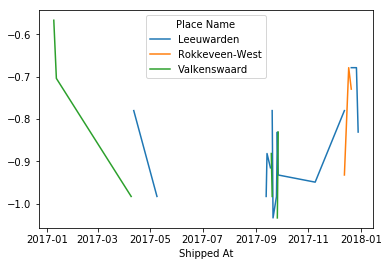

In [124]:
df_best_chart.pivot_table(values='Updated Shipped diff_normalized',columns='Place Name',index='Shipped At').plot()

In [125]:
df_best_chart

Updated Shipped diff_normalized
Place Name     State                   Latitude Longitude Shipped At                                 
Leeuwarden     Provincie Friesland     53.2000  5.7833    2017-04-12                        -0.780226
                                                          2017-12-27                        -0.678733
                                                          2017-12-21                        -0.678733
                                                          2017-12-13                        -0.780226
                                                          2017-11-09                        -0.949380
                                                          2017-09-27                        -0.932465
                                                          2017-09-26                        -0.830972
                                                          2017-09-25                        -0.983211
                                                          2017-12-29                        -0.830972
                                                          2017-09-20                        -0.780226
                                                          2017-09-18                        -0.915549
                                                          2017-09-14                        -0.881718
                                                          2017-09-13                        -0.983211
                                                          2017-08-09                        -1.008584
                                                          2017-06-12                        -0.881718
                                                          2017-05-09                        -0.983211
                                                          2017-09-21                        -1.033957
Rokkeveen-West Provincie Zuid-Holland  52.0537  4.4924    2017-12-21                        -0.729480
                                                          2017-12-18                        -0.678733
                                                          2017-08-12                        -0.881718
                                                          2017-12-13                        -0.932465
                                                          2017-05-12                        -0.830972
                                                          2017-04-12                        -0.780226
                                                          2017-07-12                        -0.830972
Valkenswaard   Provincie Noord-Brabant 51.3508  5.4597    2017-09-27                        -0.830972
                                                          2017-01-09                        -0.566582
                                                          2017-01-12                        -0.704106
                                                          2017-04-09                        -0.983211
                                                          2017-05-09                        -0.780226
                                                          2017-06-09                        -1.033957
                                                          2017-09-19                        -0.881718
                                                          2017-09-20                        -0.983211
                                                          2017-09-26                        -1.033957
                                                          2017-12-21                        -0.932465

In [126]:
df_t_worst['Shipped At'] = df_t_worst['Shipped At'].apply(lambda x: x.date())
df_worst_chart = pd.DataFrame(df_t_worst[df_t_worst['Place Name'].isin(['Diemen','Stadscentrum','Eindhoven'])]
                    .groupby(['Place Name','State','Latitude','Longitude','Shipped At'])['Updated Shipped diff_normalized']
             .mean()).sort_values(by='Place Name',ascending=True)

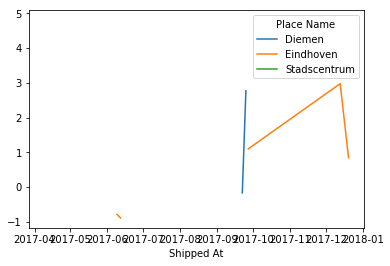

In [127]:
df_worst_chart.pivot_table(values='Updated Shipped diff_normalized',columns='Place Name',index='Shipped At').plot()

In [128]:
df_worst_chart

Updated Shipped diff_normalized
Place Name   State                   Latitude Longitude Shipped At                                 
Diemen       Provincie Noord-Holland 52.3396  4.9626    2017-04-09                        -0.435004
                                                        2017-09-15                         2.213805
                                                        2017-09-22                        -0.171271
                                                        2017-09-25                         2.772014
Eindhoven    Provincie Noord-Brabant 51.4408  5.4778    2017-06-09                        -0.790016
                                                        2017-06-12                        -0.891449
                                                        2017-09-27                         1.097386
                                                        2017-12-13                         2.974999
                                                        2017-12-20                         0.843655
Stadscentrum Provincie Zuid-Holland  52.0537  4.4924    2017-06-09                        -0.038347
                                                        2017-09-13                         4.801865
                                                        2017-09-20                         1.122760
                                                        2017-09-27                        -0.069778

# 8. Conclusion

I investigated delivery quality by creating a metric based on local frequency distributions in time for parcels, selecting those ranges can be on of the weeknesses of the metric because it requires human input and it can change person to person, the other weekness part of the metric is that it's not symetric meaning that if you move from zero to -1 or zero to +1, those shifts don't show the same impact for quality because of the right skewed disribution (many parcel are delivered in a few days and many few are delivered in weeks or months)

There is also an advantage of the metric that is it captures local variance, in my approach first interval (0,500) hours, so companies fighting for quick delivery can be comparable and if they have more frequency in that range they get more weight.


There might be other approaches to measure quality. Like geometric series we can give less weight to the recent observations and more weight to the late deliveries.

Delivery quality doesn't only start from "Shipped At" to "Updated At" , there is also a part from "Created At" to "Updated At", in this task I assumed that investigating carrier performance is important and assumed that it's also more important for you to see the carrier performance, in a real scenario both ranges should be investigated.

For the visualisation and/or comparing periods quastion that is asked in task , I don't see too many data points to slice and dice or visualize, just to show as an example I shared the data and visualisations. Daily data is very riski to see high variation depending on the delivery type.


What are the action that we can take?
 * Create more metrics and see if there are correlations in other approaches
 * Create charts to see sudden changes in the data
 * Use alerters to catch outliers ( slack message when quality is getting worse than %5 percent ) 
 * Inform the carrier to investigate the real cause of the problem